# Conebeam reconstruction from numerical phantom
For the study of reconstruction methods it is of interest to study the accuracy of reconstruction
. Here the SART method is studied in its simplest form, without regularization or 
smoothing/filtering terms.

We simulate the flow of an ellipsoid bubble, that is slightly rotated, through the column. In the
 $\hat e_3$ plane there are some artifacts appearing in the corners of the slice, as well as 
 around the bubble. The inversion was not fully correct here, mostly due to the limited-angle 
 reconstruction.
 
We show that we can improve a bit on this by adding regularization, or iterating the method for a
 longer time. Note these are crude methods and can still be improved a lot if we would incorporate 
 knowledge about the bubbles or their motion.

In [2]:
from fbrct import *
from fbrct.phantom import *
from fbrct.util import *

In [3]:
recon_height_range = range(774 - 350, 774 + 350)
recon_height_length = int(len(recon_height_range))
n = 50  # reconstruction on a n*n*m grid
L = 10  # -L cm to L cm in the physical space
# scale amount of pixels and physical height according to the selected reconstruction range
m = max(int(np.floor(n / DETECTOR_ROWS * recon_height_length)), 1)
H = L * m / n  # physical height

In [4]:
apart = uniform_angle_partition()
dpart = detector_partition_3d(recon_height_length)
geometry = odl.tomo.ConeFlatGeometry(apart, dpart, SOURCE_RADIUS, DETECTOR_RADIUS)
reco_space_3d = odl.uniform_discr(
    min_pt=[-L, -L, -H],
    max_pt=[L, L, H],
    shape=[n, n, m])
xray_transform = odl.tomo.RayTransform(reco_space_3d, geometry)

In [5]:
p = generate_3d_phantom_data(PHANTOM_3D_SIMPLE_ROTATED_ELLIPSOID, L, H, n, m, geometry)

## Simple SART reconstruction
Here we make a simple SART reconstion, without filtering. Note at $t=7\dots 12$ or so, that the 
bubble is not perfectly sphereical. 

Detectors at t= 3


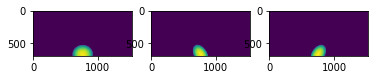

Reconstruction at t= 3


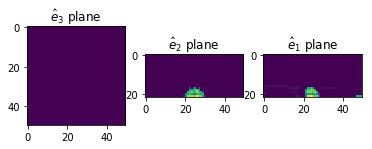

--------------------------------------------------
Detectors at t= 6


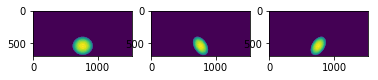

Reconstruction at t= 6


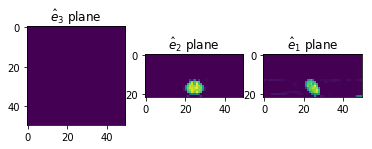

--------------------------------------------------
Detectors at t= 9


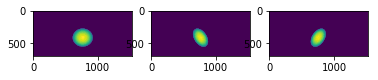

Reconstruction at t= 9


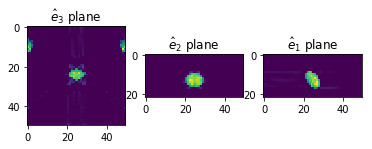

--------------------------------------------------
Detectors at t= 10


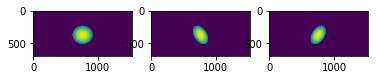

Reconstruction at t= 10


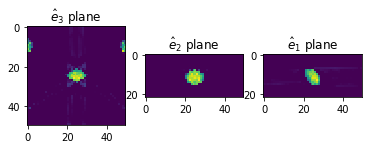

--------------------------------------------------
Detectors at t= 11


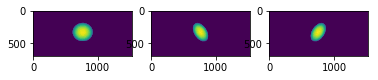

Reconstruction at t= 11


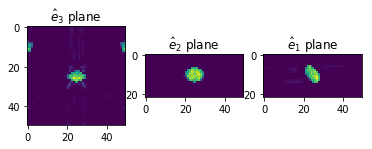

--------------------------------------------------


In [8]:
timerange = np.array([3,6,9,10,11])
for t in timerange:
    print("Detectors at t=", t)
    sinogram = p[t, ...]
    plot_sino(sinogram)

    x = xray_transform.domain.element(np.zeros(xray_transform.domain.shape))
    reconstruct_filter(
        xray_transform,
        sinogram,
        x,
        niter=150,
        clip=[0, None])

    print("Reconstruction at t=", t)
    plot_3d(x.data)
    print('-'*50)


## Make less iterations
Here we redo iteration $t=11$ but iterate less. The artifacts become more present. And the 
corner values are evidently a result of the solver storing a big deal of the "unexplained pixel intensity" at the detector at the beginning/end of the X-rays and smearing some of it out over the ray path as well.

Detectors at t= 11


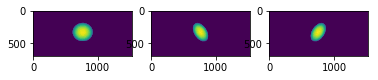

Reconstruction at t= 11


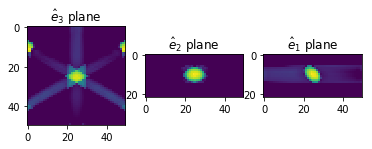

--------------------------------------------------


In [31]:
t=11
print("Detectors at t=", t)
sinogram = p[t, ...]
plot_sino(sinogram)

x = xray_transform.domain.element(np.zeros(xray_transform.domain.shape))
reconstruct_filter(
    xray_transform,
    sinogram,
    x,
    niter=10,
    clip=[0, None])

print("Reconstruction at t=", t)
plot_3d(x.data)

## Make more iterations
Here we redo iteration $t=11$ but iterate more. The artifacts disappear, but not completely. 
The inversion eliminates the weird corner values, but it does so at the cost of the shape of the 
bubble. Although it can definitely be improved, I'm still impressed how good a reconstruction can be, even in the absence of sophisticated regularization methods.

Detectors at t= 11


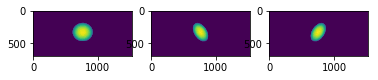

Reconstruction at t= 11


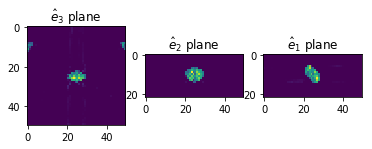

In [9]:
t=11
print("Detectors at t=", t)
sinogram = p[t, ...]
plot_sino(sinogram)

x = xray_transform.domain.element(np.zeros(xray_transform.domain.shape))
reconstruct_filter(
    xray_transform,
    sinogram,
    x,
    niter=2000,
    clip=[0, None])

print("Reconstruction at t=", t)
plot_3d(x.data)


## Add a mask
Apparently the corners of the object volume are an "easy spot" for the solver to explain detector pixels. These cells are only visible on one detector, so the solver sees no mismatch on the other detectors. We can steer the solver in the right direction by adding a mask. As you can see this is an easy way to improve the reconstruction a bit:

Detectors at t= 11


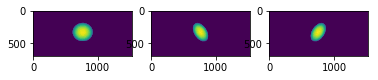

Reconstruction at t= 11


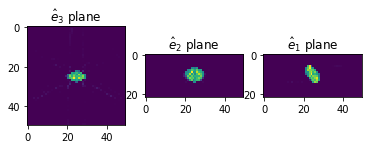

In [9]:
t=11
print("Detectors at t=", t)
sinogram = p[t, ...]
plot_sino(sinogram)

x = xray_transform.domain.element(np.zeros(xray_transform.domain.shape))
reconstruct_filter(
    xray_transform,
    sinogram,
    x,
    niter=500,
    mask=column_mask([n,n,m]),
    clip=[0, None])

print("Reconstruction at t=", t)
plot_3d(x.data)

## Use a median filter
Now we add a **median filter**. During the SART iteration, every iteration step is smoothed out 
somewhat. It comes at quite some performance cost, but the implementation here in Python is very 
slow and should be transferred to C++ or the GPU.

The median-filter iteration is applied and then $\alpha$-weight averaged with the SART iteration.
 If averaging 
does not take place, the smoothing step is too strong and counteracts the reconstruction step.

It is safe to say that it looks more esthetically pleasing (and probably easier to analyze) but 
the question remains if the imposed method does not truncate too much "bubble information".


Detectors at t= 11


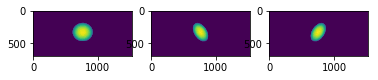

Reconstruction at t= 11


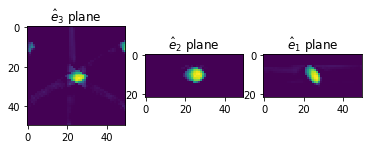

In [53]:
t=11
print("Detectors at t=", t)
sinogram = p[t, ...]
plot_sino(sinogram)
alpha = 0.05

x = xray_transform.domain.element(np.zeros(xray_transform.domain.shape))
reconstruct_filter(
    xray_transform,
    sinogram,
    x,
    fn_filter=lambda u: alpha * medians_3d(u) + (1-alpha) * u,
    niter=150,
    clip=[0, None])

print("Reconstruction at t=", t)
plot_3d(x.data)